In [1]:
%cd /Users/amarmesic/Documents/tudelft/thesis/dna

/Users/amarmesic/Documents/tudelft/thesis/dna


In [10]:
%cd /Users/amarmesic/Documents/tudelft/thesis/dna

/Users/amarmesic/Documents/tudelft/thesis/dna


# We calculate Frechet distance pairwise 3-way
## First we must obtain our tensors/arrays
### *Synthetic data*: obtain here the (100, 6*5000) array

In [11]:
import numpy as np
import pandas as pd
import glob
import os
from tensorflow.keras.models import load_model

from TGAN.generate import epg_from_df, generate_random_latent, preprocess_epg

In [38]:
# preprocess using normalization
def zscore_normalize_sample(sample):
    mean = np.mean(sample)
    std = np.std(sample)
    return (sample - mean) / (std + 1e-8)

In [39]:
n_samples = 100

In [40]:
def generate_synthetic_data(csv_dir="./TGAN/generated_alleles", samples=100):

    # Load your generator model here (adjust path as needed)
    generator = load_model('./TGAN_model/Profile_generator_GAN_trained_model_random_24-09-2023.h5')
    batch_size = samples # Set to 1 unless I explicitly want to batch process multiple EPGs per file

    # Find all relevant CSV files
    csv_files = sorted(glob.glob(os.path.join(csv_dir, "simulated_epg_with_dyes_seed_*.csv")))
    dfs = map(pd.read_csv, csv_files)

    # Prepare input EPGs
    synth_epg_data = [epg_from_df(df) for df in dfs]
    preprocessed_synth_epg_data = [preprocess_epg(synth_epg) for synth_epg in synth_epg_data]
    ndarray_synth_epg_data = np.concatenate(preprocessed_synth_epg_data, axis=0)

    # Generate latent vector
    latent = generate_random_latent(batch_size=batch_size, n_lanes=6, length=500)

    generated_epg = generator.predict([ndarray_synth_epg_data, latent])
    return generated_epg  # shape: (batch_size, n_lanes, epg_length, 1)

In [41]:
# Running takes a few secs, best to use sparingly
synthetic_data = generate_synthetic_data(samples=n_samples)

4/4 [==============================] - 8s 1s/step


In [42]:
# confirmed, this reshapes correctly!
shaped_synthetic_data = synthetic_data.squeeze().reshape(n_samples, 6*5000)[:, :-5000]  # Remove the last 5000 columns representing the ladder
synthetic_preprocessed = np.array([zscore_normalize_sample(sample) for sample in shaped_synthetic_data])
synthetic_preprocessed.shape

(100, 25000)

### Real GlobalFiler 5sec data

In [43]:
real_gf_raw_data = np.load("./SGD_validation/real_gf_epgs.npy")
real_gf_raw_data_shaped = real_gf_raw_data[:100, :, 4000:9000, np.newaxis]
real_gf_raw_data_shaped = real_gf_raw_data_shaped.reshape(100, 6*5000)[:, :-5000]
real_gf_raw_data_shaped.shape

(100, 25000)

In [44]:
real_gf_preprocessed = np.array([zscore_normalize_sample(sample) for sample in real_gf_raw_data_shaped])
real_gf_preprocessed.shape

(100, 25000)

### Real GlobalFiler 25sec data

In [45]:
real_gf_25_raw_data = np.load("./SGD_validation/real_gf_25_epgs.npy")
real_gf_25_raw_data_shaped = real_gf_25_raw_data[:100, :, 4000:9000, np.newaxis]
real_gf_25_raw_data_shaped = real_gf_25_raw_data_shaped.reshape(100, 6*5000)[:, :-5000]
print(real_gf_25_raw_data_shaped.shape)
real_gf_25_preprocessed = np.array([zscore_normalize_sample(sample) for sample in real_gf_25_raw_data_shaped])
print(real_gf_25_preprocessed.shape)

(100, 25000)
(100, 25000)


In [46]:
real_gf_25_preprocessed = np.array([zscore_normalize_sample(sample) for sample in real_gf_25_raw_data_shaped])
real_gf_25_preprocessed.shape

(100, 25000)

### Real NFI data

In [47]:
real_nfi_raw_data = np.load("./SGD_validation/real_nfi_epgs.npy")
real_nfi_raw_data_shaped = real_nfi_raw_data[:100, :, 4000:9000, np.newaxis]
real_nfi_raw_data_shaped = real_nfi_raw_data_shaped.reshape(100, 6*5000)
real_nfi_raw_data_shaped.shape

(100, 30000)

In [48]:
real_nfi_preprocessed = np.array([zscore_normalize_sample(sample) for sample in real_nfi_raw_data_shaped])[:, :-5000]
real_nfi_preprocessed.shape

(100, 25000)

# Calculate Frechet distances

## Runs a bit slow with 100 samples, memory is troubled. Solution:
* Downsample data to have 10K scan points total instead of 30K
* Use fewer samples

In [49]:
from scipy.linalg import sqrtm

def frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)

    # Handle imaginary components from sqrtm
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

In [50]:
synthetic_preprocessed[:, ::3].shape

(100, 8334)

In [51]:
synthetic_preprocessed_mini = synthetic_preprocessed[::2, ::5]
real_gf_preprocessed_mini = real_gf_preprocessed[::2, ::5]
real_gf_25_preprocessed_mini = real_gf_25_preprocessed[::2, ::5]
real_nfi_preprocessed_mini = real_nfi_preprocessed[::2, ::5]

In [ ]:
real_nfi_preprocessed.sum(axis=0), real_gf_preprocessed.sum(), real_gf_25_preprocessed.sum(), synthetic_preprocessed.sum()

(56581.93400933531,
 -2.5295321393059567e-12,
 -1.0800249583553523e-12,
 -0.0022277832)

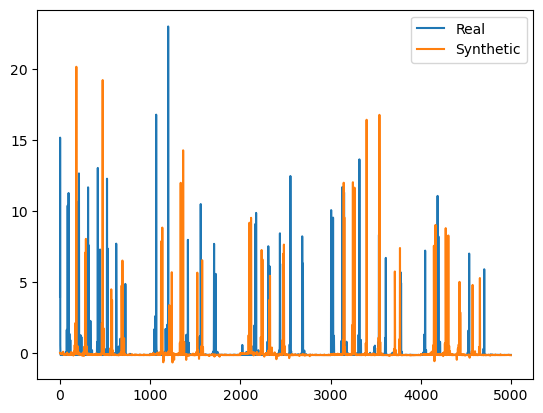

In [53]:
from matplotlib import pyplot as plt


plt.plot(real_nfi_preprocessed_mini[10].flatten(), label="Real")
plt.plot(synthetic_preprocessed_mini[10].flatten(), label="Synthetic")
plt.legend()

In [60]:
mu_real_gf = np.mean(real_gf_preprocessed_mini, axis=1)
mu_real_gf_25 = np.mean(real_gf_25_preprocessed_mini, axis=1)
mu_real_nfi = np.mean(real_nfi_preprocessed_mini, axis=1)
mu_fake = np.mean(synthetic_preprocessed_mini, axis=1)

sigma_real_gf = np.cov(real_gf_preprocessed_mini, rowvar=False)
sigma_real_gf_25 = np.cov(real_gf_25_preprocessed_mini, rowvar=False)
sigma_real_nfi = np.cov(real_nfi_preprocessed_mini, rowvar=False)
sigma_fake = np.cov(synthetic_preprocessed_mini, rowvar=False)

In [ ]:
# here we can assume that real refers to gf
frechet_distance_gf_synth = frechet_distance(mu_real_gf, sigma_real_gf, mu_fake, sigma_fake)
print(f"Fréchet Distance between Real Global Filer data (5sec) and Synthetic: {frechet_distance_gf_synth:.4f}")

Fréchet Distance between Real Global Filer data and Synthetic: 6922.6942


In [63]:
# here we can assume that real refers to gf
frechet_distance_gf_synth = frechet_distance(mu_real_gf, sigma_real_gf, mu_real_gf_25, sigma_real_gf_25)
print(f"Fréchet Distance between Real Global Filer data (5sec) and Global Filer data (25sec): {frechet_distance_gf_synth:.4f}")

Fréchet Distance between Real Global Filer data (5sec) and Global Filer data (25sec): 3887.6443


In [61]:
# here we can assume that real refers to gf
frechet_distance_gf_25_synth = frechet_distance(mu_real_gf_25, sigma_real_gf_25, mu_fake, sigma_fake)
print(f"Fréchet Distance between Real Global Filer (25sec) data and Synthetic: {frechet_distance_gf_25_synth:.4f}")

Fréchet Distance between Real Global Filer (25sec) data and Synthetic: 6956.0289


In [56]:
frechet_distance_gf_nfi = frechet_distance(mu_real_gf, sigma_real_gf, mu_real_nfi, sigma_real_nfi)
print(f"Fréchet Distance between Real Global Filer data and NFI data: {frechet_distance_gf_nfi:.4f}")

Fréchet Distance between Real Global Filer data and NFI data: 8824.5103


In [62]:
# here we can assume that real refers to gf
frechet_distance_gf_25_nfi = frechet_distance(mu_real_gf_25, sigma_real_gf_25, mu_real_nfi, sigma_real_nfi)
print(f"Fréchet Distance between Real Global Filer (25sec) data and NFI data: {frechet_distance_gf_25_nfi:.4f}")

Fréchet Distance between Real Global Filer (25sec) data and NFI data: 8806.5675


In [57]:
frechet_distance_synth_nfi = frechet_distance(mu_fake, sigma_fake, mu_real_nfi, sigma_real_nfi)
print(f"Fréchet Distance between Synthetic and NFI data: {frechet_distance_synth_nfi:.4f}")

Fréchet Distance between Synthetic and NFI data: 7505.6406


In [58]:
frechet_distance_synth_synth = frechet_distance(mu_fake, sigma_fake, mu_fake, sigma_fake)
print(f"Fréchet Distance between Real Global Filer data and Synthetic: {frechet_distance_synth_synth:.4f}")

Fréchet Distance between Real Global Filer data and Synthetic: -0.0004
